# CG EDAV.. 
* commented histograms
* some power transformations of interest
* scatterplots and subsampled scatterplots

In [1]:
import os
import numpy as np
import xarray as xr

from plotly import tools
from plotly import offline
import plotly.graph_objs as go

#import cufflinks as cf
#cf.set_config_file(offline=True)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os
os.getcwd()

'/Users/cg/co2/ocean-co2-absorption/notebooks'

# $\textbf{pCO}_2$ testbed - member 001 dataset

This contains model output from member 001 of the CESM large ensemble which can be used to evaluate ocean pCO2 interpolation methods. The dataset includes:

* pCO2 = ocean partial pressure of carbon dioxide (uatm)
* XCO2 = atmospheric carbon dioxide mixing ratio (ppmv)
* SST = sea surface temperature (degC)
* SSS = sea surface salinity (g/kg)
* MLD = mixed layer depth (m)
* CHL = chlorophyll concentration (mg/m3)

# Read each feature

In [4]:
#DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

# Print information of each dataset

In [5]:
for dataset in ds.keys():
    print("---------{}---------".format(dataset))
    print(ds[dataset].info())

---------pCO2---------
xarray.Dataset {
dimensions:
	time = 421 ;
	xlon = 360 ;
	ylat = 180 ;

variables:
	float64 pCO2_socat(time, ylat, xlon) ;
	float64 xlon(xlon) ;
		xlon:axis = X ;
	float64 ylat(ylat) ;
		ylat:axis = Y ;
		ylat:units = degrees_north ;
		ylat:point_spacing = even ;
		ylat:standard_name = latitude ;
	datetime64[ns] time(time) ;
		time:axis = T ;
		time:bounds = tmnth_bnds ;
		time:time_origin = 1-JAN-1970 ;
		time:standard_name = time ;
	float64 pCO2(time, ylat, xlon) ;
	float64 socat_mask(time, ylat, xlon) ;
	datetime64[ns] tmnth(time) ;
		tmnth:axis = T ;
		tmnth:bounds = tmnth_bnds ;
		tmnth:time_origin = 1-JAN-1970 ;
		tmnth:standard_name = time ;

// global attributes:
	:CDI = Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/cdi) ;
	:Conventions = CF-1.4 ;
	:CDO = Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/cdo) ;
	:history = Wed Apr  4 09:18:01 2018: ncap2 -s pCO2_socat=(pCO2 * socat_mask) tmp.nc pCO2_2D_mon_CESM001_1x1_198201-201712.n

## Convert xarray data to dataframe

##### Note: For consistency and not to reproduce work, using code from Lingyun's 'edav first pass' notebook to produce dataframes from .nc files

* Select corresponding features from each dataset: for example, `df['pCO2']` has both variables `pCO2_socat` (pCO2 just at SOCAT locations) and `pCO2`, so both of the two features will be converted to dataframe
* Only keep grids with finite values
* Convert pivot table to flat dataframe

In [6]:
df = {}
df_socat = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


## SSS Plots
* Pseudo-gaussian distribution, note significant peak in histogram
* While it looks like dist is skew left, there is technically almost no skew.. minimal mean/mode difference. The appearance of skew is provided by the abnormal dist exhibited between 25% and 50%. 
* Almost cauchy-esque in nature.. interesting to think about

In [7]:
df['SSS']['SSS'].describe()

count    1.729047e+07
mean     3.400026e+01
std      1.766755e+00
min      7.137795e+00
25%      3.351086e+01
50%      3.400534e+01
75%      3.481544e+01
max      4.334549e+01
Name: SSS, dtype: float64

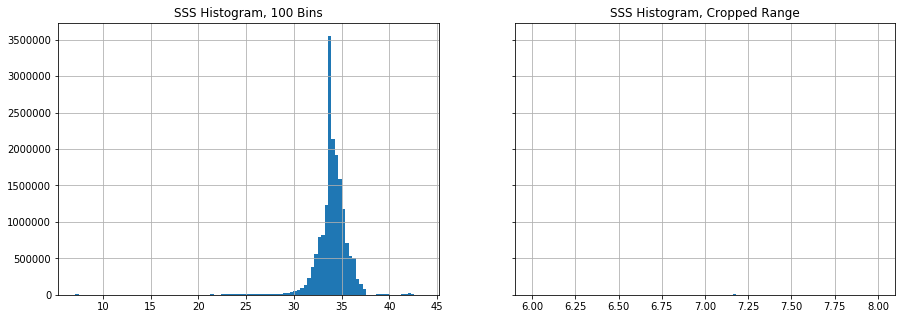

In [39]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['SSS']['SSS'].hist(ax=axs[0],bins=100).set_title('SSS Histogram, 100 Bins')
df['SSS']['SSS'].hist(ax=axs[1],bins=100,range=(6,8)).set_title('SSS Histogram, Cropped Range')

fig.show()

#plt.hist(df['SSS']['SSS'], 100)
#plt.title('SSS')
#plt.show()

## SST Plots
* Odd, non-normal distribution. Two-tails.. reminiscent of a superposition of multiple exp distributions (e.g., log-normal/gamma, or generally beta-esque (right tail)) 
* What is appropriate way to transform this data for improved uncertainty during modeling process?

In [9]:
df['SST']['SST'].describe()

count    1.729047e+07
mean     1.373404e+01
std      1.129259e+01
min     -1.936021e+00
25%      1.984551e+00
50%      1.507535e+01
75%      2.485647e+01
max      3.407636e+01
Name: SST, dtype: float64

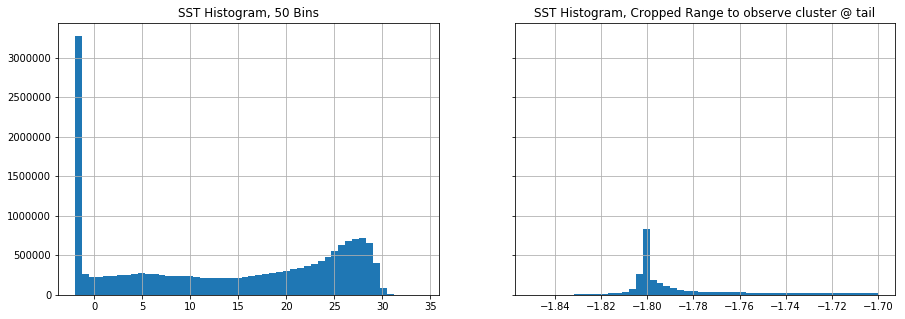

In [10]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['SST']['SST'].hist(ax=axs[0],bins=50).set_title('SST Histogram, 50 Bins')
df['SST']['SST'].hist(ax=axs[1],bins=50,range = (-1.85,-1.7)).set_title('SST Histogram, Cropped Range to observe cluster @ tail')

fig.show()

## MLD Plots
* Note right skew, perhaps log-normal
* Eval power transforms

In [11]:
df['MLD']['MLD'].describe()

count    1.729047e+07
mean     6.617619e+01
std      5.897839e+01
min      7.500032e+00
25%      3.453053e+01
50%      5.520838e+01
75%      8.387817e+01
max      1.878794e+03
Name: MLD, dtype: float64

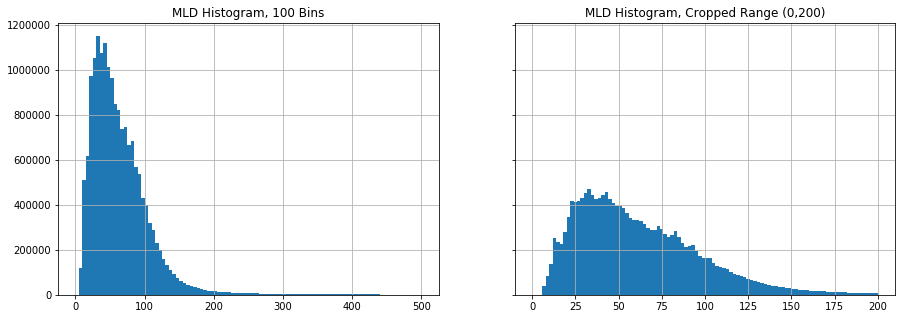

In [12]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['MLD']['MLD'].hist(ax=axs[0],bins=100, range=(0,500)).set_title('MLD Histogram, 100 Bins')
df['MLD']['MLD'].hist(ax=axs[1],bins=100,range=(0,200)).set_title('MLD Histogram, Cropped Range (0,200)')

fig.show()

## CHL Plots
* Data has extremely long tail, but 2nd and 3rd quartiles are bound to ~[0.1,0.2]. 
* Note two center modes,  combined with an erratic, difficult to describe distribution at left tail
* Multi-modal.. Strong evidence of non-gaussian behavior, or at least underlying complexity due to multiple ulderlying exponential dist

In [13]:
df['Chl']['Chl'].describe()

count    1.729047e+07
mean     3.449500e-01
std      8.521562e-01
min     -4.092084e-01
25%      1.087646e-01
50%      1.580932e-01
75%      2.111136e-01
max      1.467028e+01
Name: Chl, dtype: float64

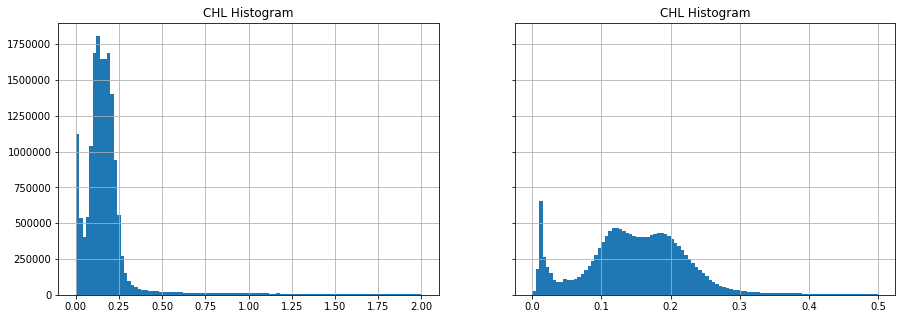

In [14]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['Chl']['Chl'].hist(ax=axs[0],bins=100, range=(0,2)).set_title('CHL Histogram')
df['Chl']['Chl'].hist(ax=axs[1],bins=100,range=(0,0.5)).set_title('CHL Histogram')

fig.show()

## XCO2 Plots
* Atmospheric co2 measurements, monthly frequency 
* Odd gap in measurements at value 380
* Note that amount of data points is far smaller here, as this is not spatially evaluated. Simply time-dependent atomospheric estimate

In [15]:
df['XCO2']['XCO2'].describe()

count    421.000000
mean     370.185059
std       18.717714
min      340.848541
25%      354.770691
50%      368.160828
75%      385.430237
max      407.208405
Name: XCO2, dtype: float64

In [16]:
df['XCO2']['XCO2'].head()

0    340.848541
1    340.962250
2    341.075439
3    341.193176
4    341.310730
Name: XCO2, dtype: float32

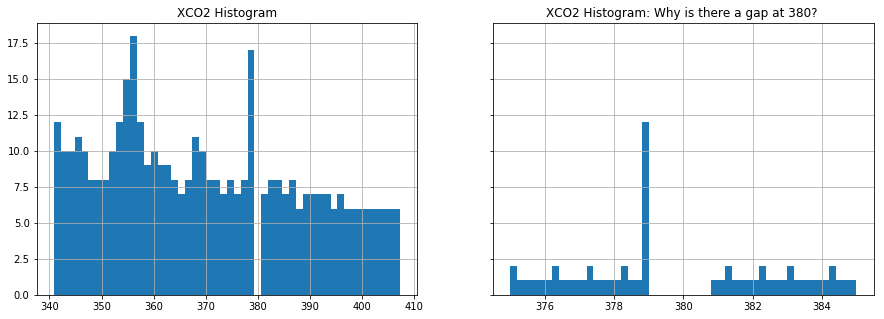

In [17]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['XCO2']['XCO2'].hist(ax=axs[0],bins=50).set_title('XCO2 Histogram')
df['XCO2']['XCO2'].hist(ax=axs[1],bins=50,range=(375,385)).set_title('XCO2 Histogram: Why is there a gap at 380? ')

fig.show()

## pCO2 Plots
* Flux,CO2 data product 
* Relatively normally distributed.. 

In [18]:
df['pCO2']['pCO2'].describe()

count    1.729047e+07
mean     3.473385e+02
std      4.455926e+01
min      1.082504e+02
25%      3.275315e+02
50%      3.491305e+02
75%      3.714645e+02
max      8.311137e+02
Name: pCO2, dtype: float64

In [19]:
df['pCO2'].head()

,time,ylat,xlon,pCO2
0,1982-01-16 12:00:00,-77.5,179.5,151.525853
1,1982-01-16 12:00:00,-77.5,180.5,150.330599
2,1982-01-16 12:00:00,-77.5,181.5,148.500409
3,1982-01-16 12:00:00,-77.5,182.5,146.198458
4,1982-01-16 12:00:00,-77.5,183.5,143.769723


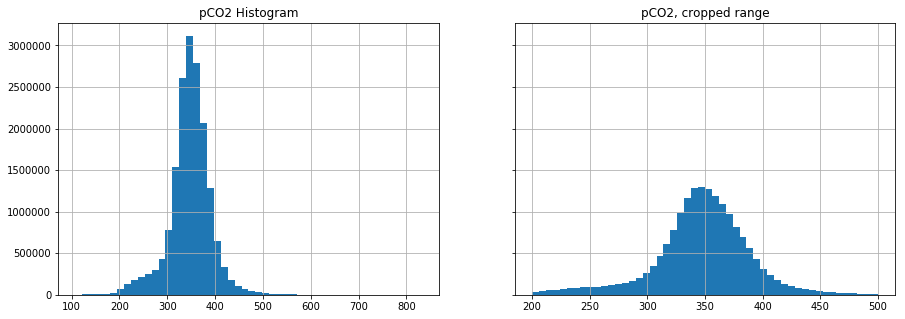

In [23]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['pCO2']['pCO2'].hist(ax=axs[0],bins=50).set_title('pCO2 Histogram')
df['pCO2']['pCO2'].hist(ax=axs[1],bins=50,range=(200,500)).set_title('pCO2, cropped range')

fig.show()

## Power Transforms
##### In the interest of describing the distributions of the driver data more detail, power transformations are performed for MLD and SSS
* lambda = -1. is a reciprocal transform.
* lambda = -0.5 is a reciprocal square root transform.
* lambda = 0.0 is a log transform.
* lambda = 0.5 is a square root transform.
* lambda = 1.0 is no transform.

In [ ]:
from scipy.stats import boxcox

In [ ]:
df.keys()

In [ ]:
#power transformations of MLD
len = df['MLD'].shape[0]
#p_MLD = np.empty([len,5])
p_MLD = {}
lambda_list = [-0.5,0,0.5]
for i in range(3):
    p_MLD['power:'+str(lambda_list[i])] = boxcox(df['MLD']['MLD'],lambda_list[i])

In [ ]:
#power transformations of SSS
len = df['SSS'].shape[0]
#p_MLD = np.empty([len,5])
p_SSS = {}
lambda_list = [-0.5,0,0.5]
for i in range(3):
    p_SSS['power:'+str(lambda_list[i])] = boxcox(df['SSS']['SSS'],lambda_list[i])

In [ ]:
df_MLD_powers = pd.DataFrame.from_dict(p_MLD, orient = 'columns')
df_SSS_powers = pd.DataFrame.from_dict(p_SSS, orient = 'columns')

## MLD transforms

* log or square root both reasonable choices.. log(MLD) is historical choice by Landschutzer and others
* $-->$ Inclined to try with $\sqrt{MLD}$, more similar in original shape and skew
* Note that in general, we are hesitant to transform the driver data, as we want to minimize bias in our models at all costs. This may result in reduced model performance (aka higher uncertainty) than for a model based on transformed data, but such is life

In [ ]:
fig, axs = plt.subplots(1,4,sharey=True, figsize =[15,5])

df['MLD']['MLD'].hist(ax=axs[0],bins=50, range=(0,500)).set_title('MLD Histogram, 50 Bins - No Transform')
df_MLD_powers['power:-0.5'].hist(ax=axs[1],bins=50,label='reciprocal square root').set_title('MLD: reciprocal square root')
df_MLD_powers['power:0'].hist(ax=axs[2],bins=50,label='log').set_title('log(MLD)')
df_MLD_powers['power:0.5'].hist(ax=axs[3],bins=50,range=(0,60),label='square root').set_title('square root (MLD)')
  
fig.show()

#### SST Power Transformations
* Frankly, power transformations cannot resolve the weird distribution of SSS. Suspect multiple underlying factors at play here. Consider non-gaussian, possibly non-linear

In [ ]:
df_SSS_powers.describe()

In [ ]:
fig, axs = plt.subplots(1,4,sharey=True, figsize =[15,5])

df['SSS']['SSS'].hist(ax=axs[0],bins=100).set_title('SSS Histogram, 100 Bins - No Transform')
df_SSS_powers['power:-0.5'].hist(ax=axs[1],bins=100,range=(1.63,1.68),label='reciprocal square root').set_title('SSS: reciprocal square root')
df_SSS_powers['power:0'].hist(ax=axs[2],bins=100,range=(3.3,3.65),label='log').set_title('log(SSS)')
df_SSS_powers['power:0.5'].hist(ax=axs[3],bins=100,range=(9,10.5),label='square root').set_title('square root (SSS)')
  
fig.show()

## Joined data

In [24]:
joined = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['Chl']['Chl']], axis=1)

In [25]:
joined.head()

,time,ylat,xlon,SSS,MLD,SST,Chl
0,1982-01-16 12:00:00,-77.5,179.5,34.000992,16.192860,1.648732,0.923969
1,1982-01-16 12:00:00,-77.5,180.5,33.941429,15.115437,1.528921,0.968525
2,1982-01-16 12:00:00,-77.5,181.5,33.863464,14.071844,1.350243,1.024705
3,1982-01-16 12:00:00,-77.5,182.5,33.775764,13.072312,1.119088,1.095643
4,1982-01-16 12:00:00,-77.5,183.5,33.691376,12.333377,0.865820,1.176906


## Scatter plots -- MLD, SSS, SST, Chl vs. pCO2

* Note that the fully sampled scatterplots do highlight slight irregularities in the data. 
* -     E.g., SST cluster at SST ~15-17 and pCO2 ~500-700 and a fair amount of SSS data <15 that is not cleary represented in the subsampled data below. 
* -     An image has been saved in the repo of the fully sampled data. 

In [ ]:
#I don't recommend running this for all data points, it took a long time. 
#See below for subsampled data

#fig, axs = plt.subplots(2,2,sharey=True, figsize =[15,5])

#joined.plot(kind='scatter',ax=axs[0,0],x='SSS',y='pCO2',label='SSS v pCO2')
#joined.plot(kind='scatter',ax=axs[1,0],x='SST',y='pCO2',label='SST v pCO2')
#joined.plot(kind='scatter',ax=axs[0,1],x='MLD',y='pCO2',label='MLD v pCO2')
#joined.plot(kind='scatter',ax=axs[1,1],x='Chl',y='pCO2',label='Chl v pCO2')

#df_SSS_powers['power:-0.5'].hist(ax=axs[0],bins=100,range=(1.63,1.68),label='reciprocal square root').set_title('SSS: reciprocal square root')
#df_SSS_powers['power:0'].hist(ax=axs[1],bins=100,range=(3.3,3.65),label='log').set_title('log(SSS)')
#df_SSS_powers['power:0.5'].hist(ax=axs[2],bins=100,range=(9,10.5),label='square root').set_title('square root (SSS)')
  
#fig.show()

#### Interesting note.. 
* comparing SSS histogram to scatter, see that the vast majority of samples are between 30 and ~37m 
* The scatter tapers into a distinct regime at ~37, and with minimal data density on the left below 30. See below: samples with SSS below 30 make up ~1.5% of data, <25 makes up <0.5% of data 

In [37]:
length = joined['SSS'].count()
SSS_sub_25 = joined['SSS'][joined['SSS'] < 25].count()
SSS_sub_30 = joined['SSS'][joined['SSS'] < 30].count()
print ('count < 25:'+str(SSS_sub_25), 'sample size:'+str(length), '<25 fraction:'+str(SSS_sub_25/length))
print ('count < 30:'+str(SSS_sub_30), 'sample size:'+str(length), '<30 fraction:'+str(SSS_sub_30/length))
SSS_sub_5 = joined['SSS'][joined['SSS'] < 12].count()
print ('count < 5:'+str(SSS_sub_5), 'sample size:'+str(length), '<30 fraction:'+str(SSS_sub_5/length))

count < 25:81580 sample size:17290470 <25 fraction:0.0047182060406686455
count < 30:267261 sample size:17290470 <30 fraction:0.015457127539043184
count < 5:14762 sample size:17290470 <30 fraction:0.0008537651087564421


## Scatter plots -- 1% sample of MLD, SSS, SST, Chl vs. pCO2

* Plots are difficult to interpret holistically: SSS, MLD, and SST have complex behavior and erratic ranges of pCO2 values, implying underlying complexity and interaction with other factors
* Chl is interesting, in that there's cleary a negative correlation with increased Chlorophyl.. perhaps because higher amount of Chl implies that the biological cycle plays a bigger role in those regions in time and space. 
* $-->$ Remove outlier data in SSS

In [ ]:
fig2, axs = plt.subplots(2,2,sharey=True, figsize =[15,5])

joined.sample(frac=.01).plot(kind='scatter',ax=axs[0,0],x='SSS',y='pCO2',label='SSS v pCO2')
joined.sample(frac=.01).plot(kind='scatter',ax=axs[1,0],x='SST',y='pCO2',label='SST v pCO2')
joined.sample(frac=.01).plot(kind='scatter',ax=axs[0,1],x='MLD',y='pCO2',label='MLD v pCO2')
joined.sample(frac=.01).plot(kind='scatter',ax=axs[1,1],x='Chl',y='pCO2',label='Chl v pCO2')

#df_SSS_powers['power:-0.5'].hist(ax=axs[0],bins=100,range=(1.63,1.68),label='reciprocal square root').set_title('SSS: reciprocal square root')
#df_SSS_powers['power:0'].hist(ax=axs[1],bins=100,range=(3.3,3.65),label='log').set_title('log(SSS)')
#df_SSS_powers['power:0.5'].hist(ax=axs[2],bins=100,range=(9,10.5),label='square root').set_title('square root (SSS)')
  
fig2.show()

In [ ]:
fig3, axs = plt.subplots(2,2,sharey=True, figsize =[15,5])

joined.plot(kind='hexbin',ax=axs[0,0],x='SSS',y='pCO2', gridsize=15, label='SSS v pCO2')
joined.plot(kind='hexbin',ax=axs[1,0],x='SST',y='pCO2', gridsize=15, label='SST v pCO2')
joined.plot(kind='hexbin',ax=axs[0,1],x='MLD',y='pCO2', gridsize=15, label='MLD v pCO2')
joined.plot(kind='hexbin',ax=axs[1,1],x='Chl',y='pCO2', gridsize=15, label='Chl v pCO2')

#df_SSS_powers['power:-0.5'].hist(ax=axs[0],bins=100,range=(1.63,1.68),label='reciprocal square root').set_title('SSS: reciprocal square root')
#df_SSS_powers['power:0'].hist(ax=axs[1],bins=100,range=(3.3,3.65),label='log').set_title('log(SSS)')
#df_SSS_powers['power:0.5'].hist(ax=axs[2],bins=100,range=(9,10.5),label='square root').set_title('square root (SSS)')
  
fig3.show()